<a href="https://colab.research.google.com/github/Jvlia17/deep-learning/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Projekt ten ma na celu przeprowadzenie ataku aderwsarzowego metodą FGSM na głęboką sieć neuronową o architekturze typu ResNet (*Residual neural network*). W projekcie sprawdzony zostanie wpływ parametru ɛ metody FGSM. W celu przeprowadzenia eksperymentów, zostanie wytrenowana sieć ResNet na zbiorze CIFAR-10. Zostanie sprawdzona metoda obrony przed takimi atakami, tj. dodanie rozmycia do obrazu wejściowego.

Na początku zatem należy stworzyć model. Architektura modelu została zaimplementowana na podstawie [[1]](https://arxiv.org/pdf/1512.03385.pdf) oraz [[2]](https://github.com/akamaster/pytorch_resnet_cifar10). Zaimplementowano model o 110 warstwach, ResNet110, jako że jak podaje [[1]](https://arxiv.org/pdf/1512.03385.pdf), otrzymano na nim najmniejszy błąd dla zbioru CIFAR10.

https://github.com/akamaster/pytorch_resnet_cifar10

https://arxiv.org/pdf/1512.03385.pdf

https://medium.com/analytics-vidhya/resnet-10f4ef1b9d4c

https://pytorch-tutorial.readthedocs.io/en/latest/tutorial/chapter03_intermediate/3_2_2_cnn_resnet_cifar10/

https://towardsdatascience.com/resnets-for-cifar-10-e63e900524e0

https://www.kaggle.com/code/banerz/resnet-implementation-in-pytorch

https://blog.paperspace.com/writing-resnet-from-scratch-in-pytorch/



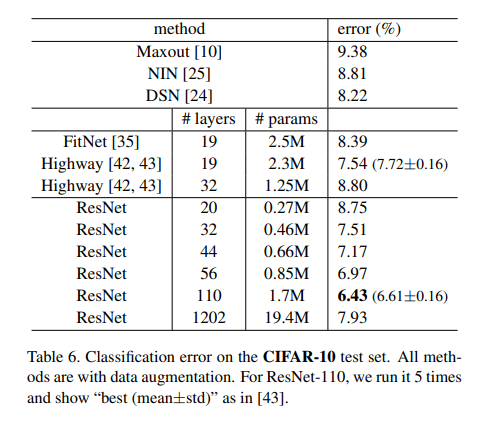

*We follow the simple data augmentation in [24] for training: 4 pixels are padded on each side,
and a 32×32 crop is randomly sampled from the padded
image or its horizontal flip. For testing, we only evaluate
the single view of the original 32×32 image.*

In [2]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4133 sha256=b9fb8fe21d8cc3d289e1404566100cfded5095a0b5bf8631a087f4a9a209b437
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
# from torchviz import make_dot
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as utils
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super().__init__()
        self.inplanes = 16
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 16, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(16),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 16, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 32, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 64, layers[2], stride = 2)
        self.fc = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = F.avg_pool2d(x, x.size()[3])
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

model = ResNet(ResidualBlock, [18,18,18]).to(device)

summary(model, (3, 32, 32))

# x = torch.randn(1,3,32, 32)
# y = model(x)

# make_dot(y.mean(), params=dict(model.named_parameters())).render("rnn_torchviz", format="png")


Wczytanie zbioru danych:

In [6]:
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
classes = trainset.classes
print(classes)

100%|██████████| 170498071/170498071 [00:05<00:00, 28474069.88it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [18]:
# calculate mean and std for the dataset
imgs_train = torch.stack([img_t for img_t ,_ in trainset],dim=3)
imgs_test = torch.stack([img_t for img_t ,_ in testset],dim=3)
imgs = torch.cat((imgs_train, imgs_test), 3)
mean = imgs.view(3,-1).mean(dim=1).numpy()
std = imgs.view(3, -1).std(dim=1).numpy()
print(mean, std)

normalize= transforms.Normalize(mean=[mean[0], mean[1], mean[2]],
                                     std=[std[0], std[1], std[2]])

[0.49186882 0.48265398 0.44717732] [0.24697122 0.24338895 0.2615926 ]


In [8]:
# data augmentation: 4 pixels are padded on each side,
# and a 32×32 crop is randomly sampled from the padded
# image or its horizontal flip

batch_size = 128

train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=batch_size, shuffle=True, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=batch_size, shuffle=True, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


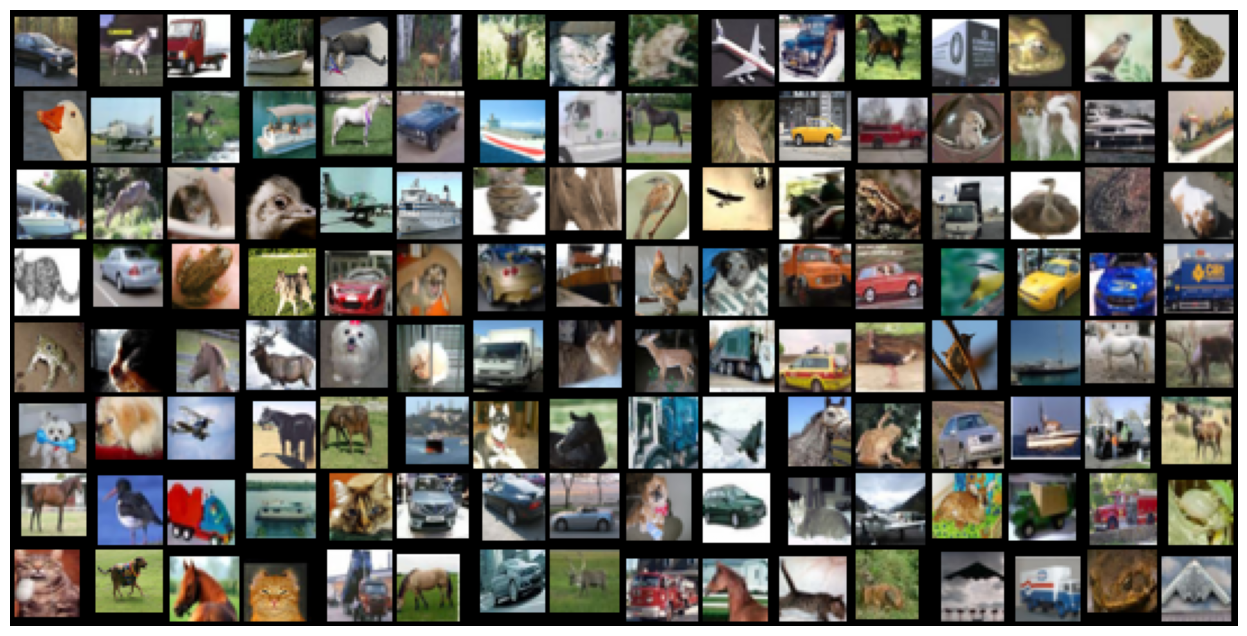

In [ ]:
for images, _ in train_loader:
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(utils.make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [8]:
# Hyper-parameters
num_epochs = 200
learning_rate = 0.001
weight_decay = 0.0001 # ??
momentum = 0.9
# when the training error is below 80% go to lr=0.1

In [ ]:
# Training the model
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torchsummary import summary
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    data_loader = tqdm(train_loader, total=len(train_loader), desc=f'Epoch [{epoch + 1}/{num_epochs}]')

    for batch_idx, (inputs, targets) in enumerate(data_loader):
        optimizer.zero_grad()
        inputs, targets = inputs.to(device), targets.to(device)


        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = outputs.max(1)
        correct_predictions += predicted.eq(targets).sum().item()
        total_samples += targets.size(0)

        # Progress bar description
        data_loader.set_postfix(loss=total_loss / (batch_idx + 1), accuracy=correct_predictions / total_samples)

    average_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_samples

    print(f'Epoch [{epoch + 1}/{num_epochs}] - Loss: {average_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')


In [ ]:
# Saving the model
model_save_path = 'resnet_cifar10.pth'
training_stats = {
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': average_loss,
    'accuracy': accuracy,
}

torch.save(training_stats, model_save_path)

In [11]:
# Loading the model

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = weight_decay, momentum = momentum)
state = torch.load('/content/resnet_cifar10.pth')
model = ResNet(ResidualBlock, [18,18,18]).to(device)
model.load_state_dict(state['model_state_dict'])
optimizer.load_state_dict(state['optimizer_state_dict'])
model.eval()

print('Acc:', state['accuracy'], '\tLoss: ', state['loss'])

Acc: 0.9454 	Loss:  0.1501430583084026


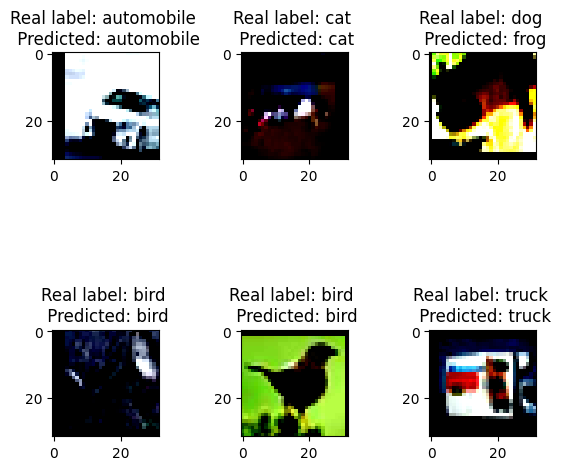

In [16]:
# Predict some examples
import math

i = 1
no_predictions = 6
col = 3
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=1.6)
for images, label in val_loader:
  for img, lbl in zip(images, label):
    if i == no_predictions + 1:
      break
    plt.subplot(int(math.ceil(no_predictions / col)), col, i)
    output = model((img.view(1,3,32,32).to(device))).to(device)
    plt.title(f"Real label: {classes[lbl.numpy()]} \n Predicted: {classes[torch.max(output.data, 1)[1][0].cpu().numpy()]}")
    plt.imshow(img.permute(1,2,0))
    i += 1
  break


Przeprowadzono zmniejszenie wymiarowości obrazów w celu porównania otrzymanych dwuwymiarowych wektrów reprezentujących różne klasy obrazów w przestrzeni cech.
Do zmniejszenia wymiarowości użyto metody PCA (*Principal Component Analysis*).

In [57]:
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns

# trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
# testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
# classes = trainset.classes
# print(classes)

# imgs_train = torch.stack([img_t for img_t ,_ in trainset],dim=3)
labels_train = np.stack([label for _, label in trainset])

x_train = imgs_train
x_train = np.copy(x_train.transpose(0,3))
x_train = x_train / 255.0
# flatten
x_train_flat = x_train.reshape(-1, x_train.shape[1] * x_train.shape[2] * x_train.shape[3])
# create dataframe
features = ['Pixel' + str(i) for i in range(x_train_flat.shape[1])]
df_cifar = pd.DataFrame(x_train_flat, columns = features)
df_cifar['Label'] = labels_train
print(df_cifar.head())


pca_model = PCA(2)
# apply PCA to each column except the last one (label)
convereted_data = pca_model.fit_transform(df_cifar.iloc[:,:-1])
df_converted_data = pd.DataFrame(data = convereted_data, columns = ['Principal Component 1', 'Principal Component 2'])
df_converted_data['Label'] = labels_train

print(df_converted_data.head())


     Pixel0    Pixel1    Pixel2    Pixel3    Pixel4    Pixel5    Pixel6  \
0  0.000907  0.000953  0.000969  0.000661  0.000707  0.000692  0.000769   
1  0.002368  0.002722  0.002876  0.001938  0.002107  0.002092  0.001615   
2  0.003922  0.003922  0.003922  0.003891  0.003891  0.003891  0.003891   
3  0.000431  0.000384  0.000154  0.000569  0.000523  0.000292  0.000584   
4  0.002614  0.002768  0.003045  0.002584  0.002737  0.003014  0.002722   

     Pixel7    Pixel8    Pixel9  ...  Pixel3063  Pixel3064  Pixel3065  \
0  0.000738  0.000661  0.001046  ...   0.003322   0.002830   0.002153   
1  0.001599  0.001461  0.001569  ...   0.002199   0.002045   0.002138   
2  0.003891  0.003891  0.003891  ...   0.001200   0.001307   0.001276   
3  0.000538  0.000308  0.000646  ...   0.000830   0.000723   0.000431   
4  0.002845  0.003122  0.002814  ...   0.001153   0.001215   0.001261   

   Pixel3066  Pixel3067  Pixel3068  Pixel3069  Pixel3070  Pixel3071  Label  
0   0.002322   0.001815   0.00129

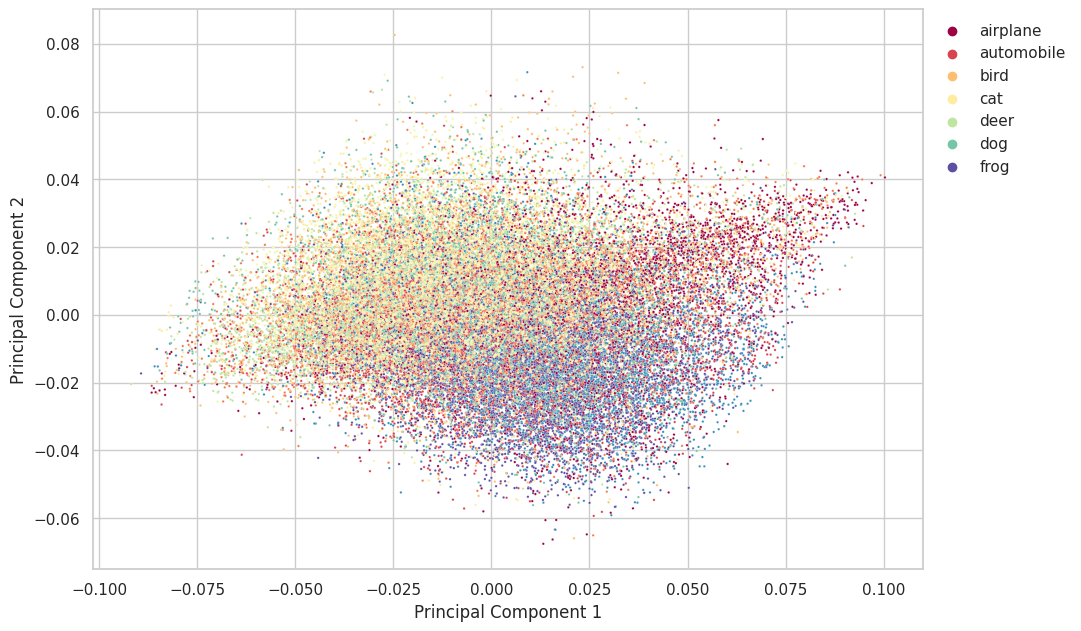

In [70]:
sns.set(rc={'figure.figsize':(10.7,7.27)})
sns.set_style("whitegrid")
g = sns.scatterplot(data=df_converted_data, x="Principal Component 1",
                y="Principal Component 2", hue="Label",
                palette=sns.color_palette("Spectral", as_cmap=True),
                s = 3)

handles, labels  =  g.get_legend_handles_labels()

g.legend(handles, classes, bbox_to_anchor=(1, 1))